# Imports

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet50, resnet101, resnet152
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet50_Weights, ResNet101_Weights, ResNet152_Weights
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
import time
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

warnings.filterwarnings("ignore")

# Data Preparation Function

In [23]:
def load_data(dataset_name, data_dir=None):
    if dataset_name == 'cifar10':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

    elif dataset_name == 'imagenet':
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        if data_dir is None:
            raise ValueError("Please provide the path to the ImageNet dataset directory.")
        train_dataset = ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
        test_dataset = ImageFolder(root=os.path.join(data_dir, 'val'), transform=transform)
        trainloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
        testloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

    else:
        raise ValueError("Invalid dataset name. Choose from 'cifar10' or 'imagenet'.")

    return trainloader, testloader

# Function to create a ResNet model

In [24]:
def create_resnet(model_name, num_classes=200):
    if model_name == 'resnet50':
        weights = ResNet50_Weights.DEFAULT
        model = resnet50(weights=weights)
    elif model_name == 'resnet101':
        weights = ResNet101_Weights.DEFAULT
        model = resnet101(weights=weights)
    elif model_name == 'resnet152':
        weights = ResNet152_Weights.DEFAULT
        model = resnet152(weights=weights)
    else:
        raise ValueError("Invalid model name. Choose from 'resnet50', 'resnet101', or 'resnet152'.")

    model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# Model Training Function

In [25]:
def train_model(model, train_loader, test_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs for training.")
        model = nn.DataParallel(model)

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    test_predictions = []
    test_labels = []
    inference_times = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        pbar = tqdm(train_loader, unit='batch', disable=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            start_time = time.time()
            outputs = model(inputs)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)
            
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        epoch_train_loss = train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        train_acc = calculate_accuracy(model, train_loader, device)
        train_accuracies.append(train_acc)

        # Evaluation on the test set
        model.eval()
        test_loss = 0.0
        test_preds = []
        test_lbls = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                start_time = time.time()
                outputs = model(inputs)
                inference_time = time.time() - start_time
                inference_times.append(inference_time)
                
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                test_preds.extend(predicted.cpu().numpy())
                test_lbls.extend(labels.cpu().numpy())

            test_predictions.append(test_preds)
            test_labels.append(test_lbls)

        epoch_test_loss = test_loss / len(test_loader)
        test_losses.append(epoch_test_loss)

        test_acc = accuracy_score(test_lbls, test_preds)
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    test_predictions = [item for sublist in test_predictions for item in sublist]
    test_labels = [item for sublist in test_labels for item in sublist]

    accuracy = accuracy_score(test_labels, test_predictions)
    precision = precision_score(test_labels, test_predictions, average='weighted')
    recall = recall_score(test_labels, test_predictions, average='weighted')
    f1 = f1_score(test_labels, test_predictions, average='weighted')
    cm = confusion_matrix(test_labels, test_predictions)

    return train_losses, train_accuracies, test_losses, test_accuracies, test_predictions, test_labels, accuracy, precision, recall, f1, cm, inference_times


def calculate_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [26]:
def plot_losses_accuracies(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plotting training metrics
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, test_losses, 'g', label='Test loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.xticks(epochs)  # Set ticks at integer epochs
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, test_accuracies, 'm', label='Test accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.xticks(epochs)  # Set ticks at integer epochs
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main Execution

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1563/1563 [01:10<00:00, 22.02batch/s, loss=0.921]


Epoch [1/10], Train Loss: 0.9726, Train Accuracy: 0.7931, Test Loss: 0.6475, Test Accuracy: 0.7880


100%|██████████| 1563/1563 [01:11<00:00, 21.91batch/s, loss=0.503]


Epoch [2/10], Train Loss: 0.6487, Train Accuracy: 0.8304, Test Loss: 0.5718, Test Accuracy: 0.8124


100%|██████████| 1563/1563 [01:11<00:00, 21.82batch/s, loss=0.658]


Epoch [3/10], Train Loss: 0.5380, Train Accuracy: 0.8563, Test Loss: 0.5584, Test Accuracy: 0.8153


100%|██████████| 1563/1563 [01:11<00:00, 21.79batch/s, loss=0.41] 


Epoch [4/10], Train Loss: 0.4637, Train Accuracy: 0.8880, Test Loss: 0.5045, Test Accuracy: 0.8308


100%|██████████| 1563/1563 [01:11<00:00, 21.93batch/s, loss=0.224] 


Epoch [5/10], Train Loss: 0.3870, Train Accuracy: 0.9025, Test Loss: 0.5055, Test Accuracy: 0.8403


100%|██████████| 1563/1563 [01:11<00:00, 21.81batch/s, loss=0.447] 


Epoch [6/10], Train Loss: 0.3419, Train Accuracy: 0.9237, Test Loss: 0.4941, Test Accuracy: 0.8420


100%|██████████| 1563/1563 [01:11<00:00, 21.95batch/s, loss=0.377] 


Epoch [7/10], Train Loss: 0.2897, Train Accuracy: 0.9276, Test Loss: 0.5038, Test Accuracy: 0.8369


100%|██████████| 1563/1563 [01:11<00:00, 21.91batch/s, loss=0.0676]


Epoch [8/10], Train Loss: 0.2406, Train Accuracy: 0.9420, Test Loss: 0.5201, Test Accuracy: 0.8411


100%|██████████| 1563/1563 [01:11<00:00, 21.91batch/s, loss=0.121] 


Epoch [9/10], Train Loss: 0.2331, Train Accuracy: 0.9402, Test Loss: 0.5703, Test Accuracy: 0.8342


100%|██████████| 1563/1563 [01:11<00:00, 21.82batch/s, loss=0.199]  


Epoch [10/10], Train Loss: 0.1982, Train Accuracy: 0.8795, Test Loss: 0.7462, Test Accuracy: 0.7888
Average Inference Time: 0.00929000802131604


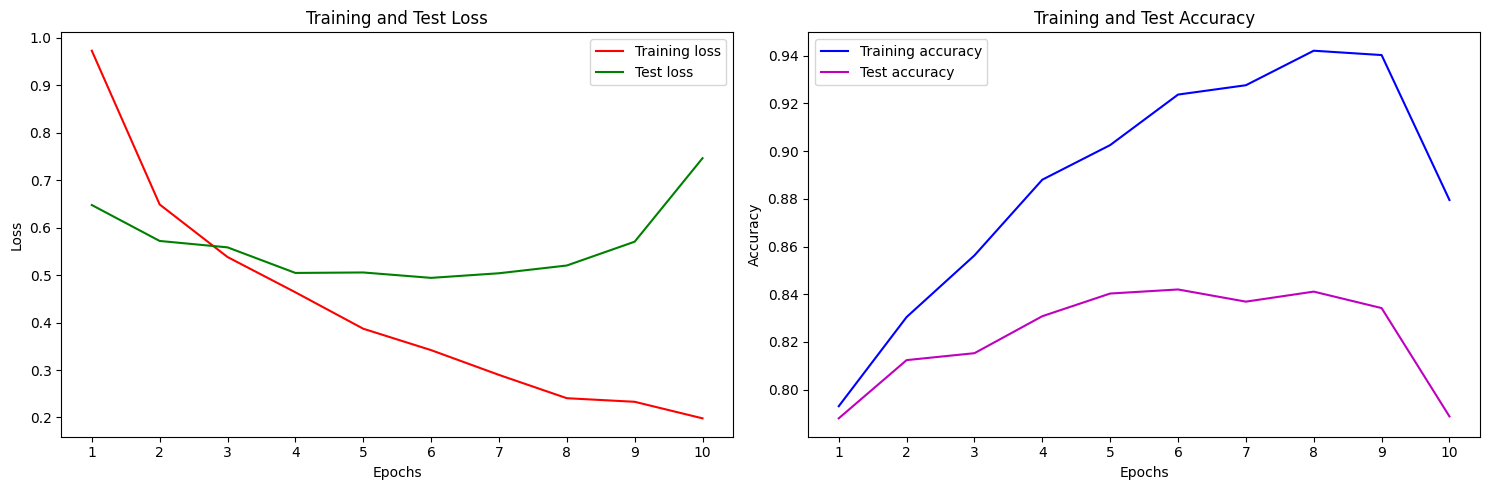

Train Losses: [0.9725768527520138, 0.6486725577618628, 0.538006545142798, 0.46371549586702904, 0.3869754118285954, 0.34187507119103644, 0.28971311817290074, 0.24060720876955635, 0.23305769163462134, 0.19819757417893075]
Train Accuracies: [0.79308, 0.83044, 0.85628, 0.888, 0.9025, 0.92366, 0.92758, 0.94204, 0.94022, 0.87948]
Val Losses: [0.6475340087002459, 0.5718314554363775, 0.5583533775596954, 0.5044773193403554, 0.5054611631999382, 0.4940858000097945, 0.5038041459818998, 0.5201208693579363, 0.5702813848519859, 0.7461795815454123]
Val Accuracies: [0.788, 0.8124, 0.8153, 0.8308, 0.8403, 0.842, 0.8369, 0.8411, 0.8342, 0.7888]
Accuracy: 0.82298
Precision: 0.8224096933413513
Recall: 0.82298
F1 Score: 0.8223730128884276
Confusion Matrix:
 [[8542  124  288  118  103   24   35   73  522  171]
 [ 131 8954   15   25   15   30   55   15  198  562]
 [ 501   20 7560  328  565  271  442  225   66   22]
 [ 194   43  402 6803  476 1184  425  307  110   56]
 [ 133   13  320  362 8310  169  271  366 

In [27]:
def main(model_name, dataset_name):
    # Configuration
    data_dir = "/kaggle/input/tiny-imagenet/tiny-imagenet-200"  # Path to the ImageNet dataset directory (required if dataset_name is 'imagenet')
    num_epochs = 10
    num_classes = 10 if dataset_name == 'cifar10' else 200  # Number of classes in the dataset

    # Load data
    train_loader, test_loader = load_data(dataset_name, data_dir)

    # Create model
    model = create_resnet(model_name, num_classes=num_classes)

    # Train model
    train_losses, train_accuracies, test_losses, test_accuracies, test_predictions, test_labels, accuracy, precision, recall, f1, cm, inference_times = train_model(model, train_loader, test_loader, num_epochs=num_epochs)

    # Print average inference time
    average_inference_time = sum(inference_times) / len(inference_times)
    print("Average Inference Time:", average_inference_time)

    # Plot training and testing metrics
    plot_losses_accuracies(train_losses, train_accuracies, test_losses, test_accuracies)

    # Print detailed statistics or visualize results further
    print("Train Losses:", train_losses)
    print("Train Accuracies:", train_accuracies)
    print("Val Losses:", test_losses)
    print("Val Accuracies:", test_accuracies)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", cm)

if __name__ == '__main__':
    model = "resnet50" # Choose from 'resnet50', 'resnet101', or 'resnet152'
    dataset = "cifar10" # Choose from 'cifar10' or 'imagenet'
    main(model,dataset)

Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:02<00:00, 83.7MB/s] 
100%|██████████| 1563/1563 [02:09<00:00, 12.08batch/s, loss=0.626]


Epoch [1/10], Train Loss: 1.0374, Train Accuracy: 0.7837, Test Loss: 0.6705, Test Accuracy: 0.7826


100%|██████████| 1563/1563 [02:09<00:00, 12.08batch/s, loss=0.462]


Epoch [2/10], Train Loss: 0.6729, Train Accuracy: 0.8354, Test Loss: 0.5926, Test Accuracy: 0.8040


100%|██████████| 1563/1563 [02:09<00:00, 12.09batch/s, loss=0.641]


Epoch [3/10], Train Loss: 0.5625, Train Accuracy: 0.8587, Test Loss: 0.5580, Test Accuracy: 0.8131


100%|██████████| 1563/1563 [02:09<00:00, 12.08batch/s, loss=0.511] 


Epoch [4/10], Train Loss: 0.4742, Train Accuracy: 0.8780, Test Loss: 0.5522, Test Accuracy: 0.8176


100%|██████████| 1563/1563 [02:09<00:00, 12.07batch/s, loss=1]     


Epoch [5/10], Train Loss: 0.4378, Train Accuracy: 0.8926, Test Loss: 0.5391, Test Accuracy: 0.8252


100%|██████████| 1563/1563 [02:09<00:00, 12.08batch/s, loss=1.35]  


Epoch [6/10], Train Loss: 0.3735, Train Accuracy: 0.9163, Test Loss: 0.5622, Test Accuracy: 0.8250


100%|██████████| 1563/1563 [02:09<00:00, 12.07batch/s, loss=0.207] 


Epoch [7/10], Train Loss: 0.3090, Train Accuracy: 0.9250, Test Loss: 0.5275, Test Accuracy: 0.8313


100%|██████████| 1563/1563 [02:09<00:00, 12.05batch/s, loss=0.181] 


Epoch [8/10], Train Loss: 0.2370, Train Accuracy: 0.9411, Test Loss: 0.5731, Test Accuracy: 0.8339


100%|██████████| 1563/1563 [02:09<00:00, 12.06batch/s, loss=0.545] 


Epoch [9/10], Train Loss: 0.2255, Train Accuracy: 0.9572, Test Loss: 0.5316, Test Accuracy: 0.8450


100%|██████████| 1563/1563 [02:09<00:00, 12.06batch/s, loss=0.863] 


Epoch [10/10], Train Loss: 0.1860, Train Accuracy: 0.9513, Test Loss: 1.4859, Test Accuracy: 0.8177
Average Inference Time: 0.01788862797497178


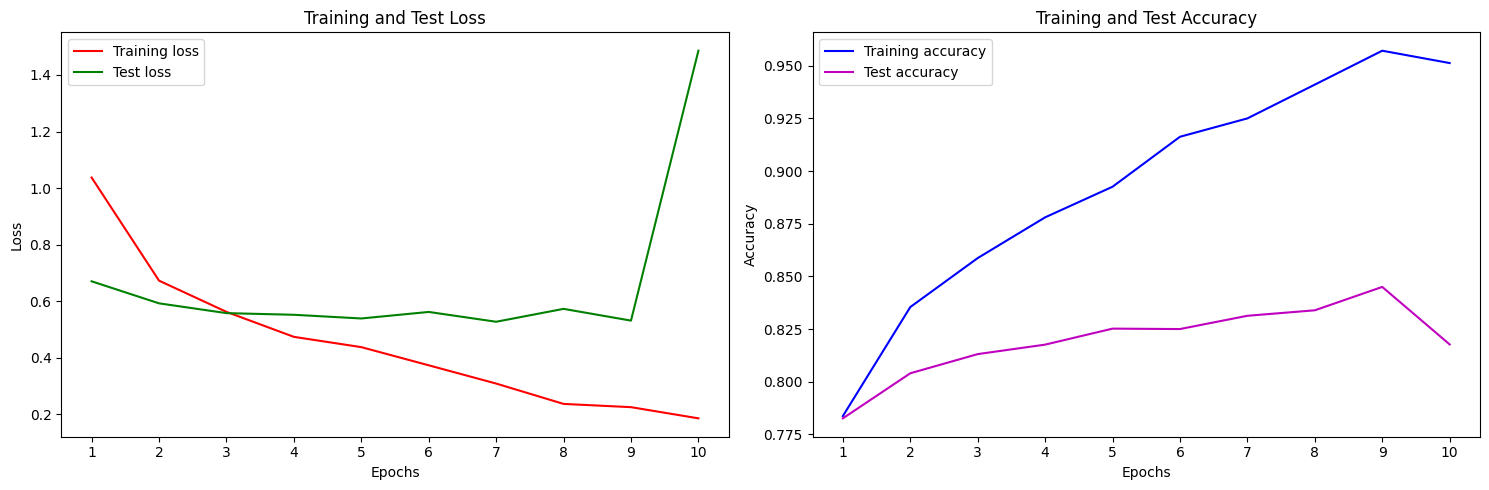

Train Losses: [1.037438052477016, 0.6728567225537999, 0.5624910138943069, 0.4741582629709997, 0.43777180854910397, 0.37354689931719826, 0.30901349813189366, 0.23703953714222573, 0.2255375230385757, 0.1860155170313866]
Train Accuracies: [0.78368, 0.83544, 0.8587, 0.87804, 0.89258, 0.9163, 0.92502, 0.94106, 0.95716, 0.9513]
Val Losses: [0.6705137551211702, 0.592613919617269, 0.5580072302502185, 0.5521859961529129, 0.5391207754183501, 0.5622123168013728, 0.5275266703944237, 0.5731174995581182, 0.5315581971464066, 1.485866594857301]
Val Accuracies: [0.7826, 0.804, 0.8131, 0.8176, 0.8252, 0.825, 0.8313, 0.8339, 0.845, 0.8177]
Accuracy: 0.81954
Precision: 0.8198803462365194
Recall: 0.81954
F1 Score: 0.819244791842153
Confusion Matrix:
 [[8700   94  234  131  132   14   38   75  434  148]
 [ 152 8667   42   43   15   33   54   15  409  570]
 [ 477   20 7709  403  485  306  322  160   77   41]
 [ 200   29  520 6897  432  985  440  304  102   91]
 [ 162   16  405  368 8135  205  319  321   55  

In [28]:
if __name__ == '__main__':
    model = "resnet101" # Choose from 'resnet50', 'resnet101', or 'resnet152'
    dataset = "cifar10" # Choose from 'cifar10' or 'imagenet'
    main(model,dataset)

Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 163MB/s]  
100%|██████████| 1563/1563 [03:00<00:00,  8.65batch/s, loss=1.04] 


Epoch [1/10], Train Loss: 1.2377, Train Accuracy: 0.6868, Test Loss: 1.5391, Test Accuracy: 0.6693


100%|██████████| 1563/1563 [03:00<00:00,  8.65batch/s, loss=1.24] 


Epoch [2/10], Train Loss: 0.7804, Train Accuracy: 0.8092, Test Loss: 0.6491, Test Accuracy: 0.7794


100%|██████████| 1563/1563 [03:01<00:00,  8.61batch/s, loss=0.719]


Epoch [3/10], Train Loss: 0.6098, Train Accuracy: 0.8412, Test Loss: 0.6219, Test Accuracy: 0.7985


100%|██████████| 1563/1563 [03:01<00:00,  8.62batch/s, loss=0.172] 


Epoch [4/10], Train Loss: 0.5343, Train Accuracy: 0.8619, Test Loss: 0.6941, Test Accuracy: 0.8031


100%|██████████| 1563/1563 [03:02<00:00,  8.58batch/s, loss=0.796] 


Epoch [5/10], Train Loss: 0.4497, Train Accuracy: 0.8831, Test Loss: 0.5733, Test Accuracy: 0.8136


100%|██████████| 1563/1563 [03:02<00:00,  8.57batch/s, loss=0.179] 


Epoch [6/10], Train Loss: 0.3813, Train Accuracy: 0.9011, Test Loss: 0.6479, Test Accuracy: 0.8078


100%|██████████| 1563/1563 [03:01<00:00,  8.60batch/s, loss=0.381] 


Epoch [7/10], Train Loss: 0.3176, Train Accuracy: 0.9282, Test Loss: 0.5355, Test Accuracy: 0.8297


100%|██████████| 1563/1563 [03:01<00:00,  8.63batch/s, loss=0.252] 


Epoch [8/10], Train Loss: 0.3029, Train Accuracy: 0.9257, Test Loss: 1.2910, Test Accuracy: 0.7935


100%|██████████| 1563/1563 [03:01<00:00,  8.62batch/s, loss=0.0974]


Epoch [9/10], Train Loss: 0.2551, Train Accuracy: 0.9533, Test Loss: 0.6737, Test Accuracy: 0.8327


100%|██████████| 1563/1563 [03:01<00:00,  8.63batch/s, loss=0.354] 


Epoch [10/10], Train Loss: 0.1994, Train Accuracy: 0.9530, Test Loss: 0.9810, Test Accuracy: 0.8238
Average Inference Time: 0.026644493204190024


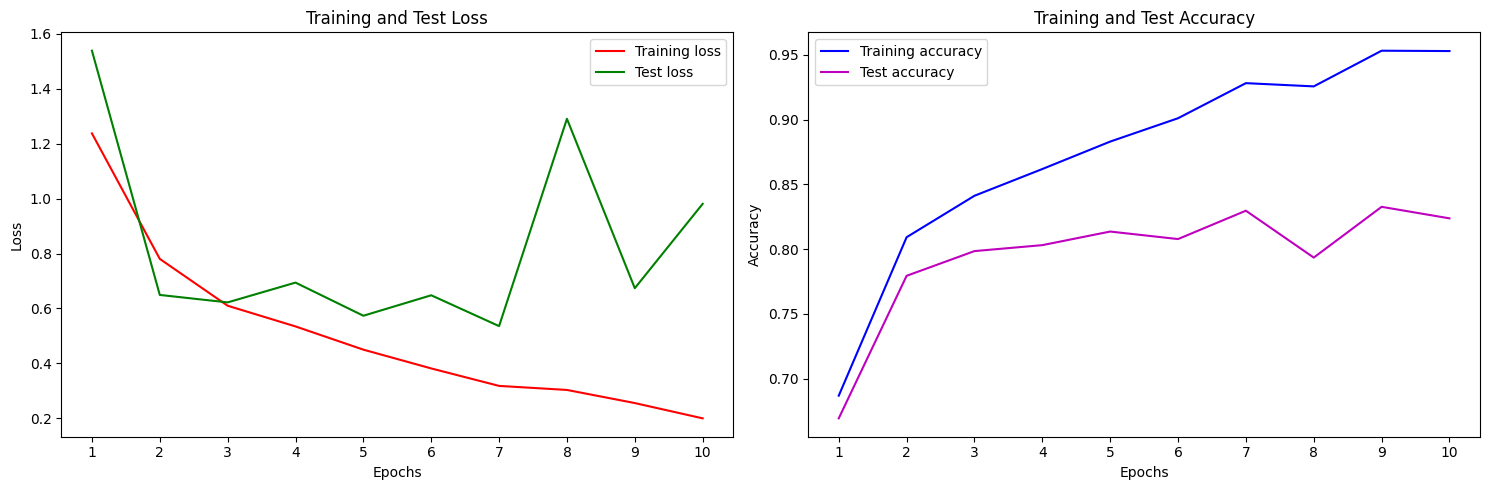

Train Losses: [1.2377270432862424, 0.7804410981773491, 0.6098038125652117, 0.5343494415569214, 0.44972579056302936, 0.3812767431969377, 0.3176354710310602, 0.30289093796843075, 0.25508862580110153, 0.1994164503094283]
Train Accuracies: [0.6868, 0.80922, 0.84124, 0.8619, 0.8831, 0.90114, 0.92824, 0.92574, 0.9533, 0.95304]
Val Losses: [1.5390860959173391, 0.6491236926648564, 0.6219470061528416, 0.6940685132155403, 0.5732954443929295, 0.6478790543235529, 0.5354982006092803, 1.2910006326227523, 0.6736560492945937, 0.9809710832830435]
Val Accuracies: [0.6693, 0.7794, 0.7985, 0.8031, 0.8136, 0.8078, 0.8297, 0.7935, 0.8327, 0.8238]
Accuracy: 0.79514
Precision: 0.7948637196682781
Recall: 0.79514
F1 Score: 0.794727069901802
Confusion Matrix:
 [[8308  191  282  142  131   43  167   97  416  223]
 [ 108 8855   33  108   16   67   60   19  219  515]
 [ 479   36 7409  368  535  411  474  172   64   52]
 [ 170   74  521 6271  454 1563  473  302   84   88]
 [ 153   17  468  421 7810  283  259  493   

In [29]:
if __name__ == '__main__':
    model = "resnet152" # Choose from 'resnet50', 'resnet101', or 'resnet152'
    dataset = "cifar10" # Choose from 'cifar10' or 'imagenet'
    main(model,dataset)